In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
# other dependencies
#!pip install timm ipywidgets

In [4]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [5]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [7]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [8]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [9]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [10]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [11]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [12]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [13]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [14]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [15]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [16]:
USE_SHORT_AUDIO = True

In [17]:
df_offset = get_offsets_df(df, short_audio=USE_SHORT_AUDIO)

In [18]:
df_offset

,id,offset,length,specie_ind
0,53,0,0.463456,2
1,57,0,0.170249,2
2,61,0,0.104041,2
3,69,0,0.274290,2
4,56,0,0.420894,2
...,...,...,...,...
151807,3561,71681,11.614280,8
151808,3561,74241,11.614280,8
151809,3552,0,2.920249,8
151810,3552,2561,2.920249,8


In [19]:
from sklearn.model_selection import train_test_split

df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [20]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [21]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [22]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [23]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.36047297 0.75794737 4.66124544 0.81193174 2.96741189 5.73006605
 3.83224865 8.62255946 0.38881485]


In [24]:
len(df_val_offset)

24290

In [25]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "Test")

DF type = Test
i = 0
9409
DF type = Test
i = 1
4484
DF type = Test
i = 2
722
DF type = Test
i = 3
4154
DF type = Test
i = 4
1140
DF type = Test
i = 5
600
DF type = Test
i = 6
823
DF type = Test
i = 7
407
DF type = Test
i = 8
8624


In [26]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [27]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    #print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [28]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [29]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [30]:
def concat_df(df_offset, indices):
    list_df_ind = []
    #print("len of indices = " + str(len(indices)))
    for ind in indices :
        df_name = "df_"+ str(ind)
        df_name = df_offset[df_offset['specie_ind'] == ind]
        list_df_ind.append(df_name)
    df_offset_trimmed = pd.concat(list_df_ind)
    return(df_offset_trimmed)

In [31]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [32]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [33]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [34]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,45232,220205,97281,15.36,8
1,139590,207169,2561,2.56,0
2,57572,221319,168961,40.90,3
3,2055,199937,74241,53.50,8
4,104211,222225,174081,30.72,1


In [35]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [36]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_train_acc = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_acc.append(train_acc)
        val_loss, val_acc , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_acc))
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)
        
        acc_metric = val_acc
        best_acc_metric = best_val_acc
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion, classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [37]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_zero(waveform)
        else:
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [38]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [39]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [40]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [41]:
df_train_offset

,index,id,offset,length,specie_ind
0,45232,220205,97281,15.360000,8
1,139590,207169,2561,2.560000,0
2,57572,221319,168961,40.900000,3
3,2055,199937,74241,53.500000,8
4,104211,222225,174081,30.720000,1
...,...,...,...,...,...
97154,27279,220863,79361,17.860000,6
97155,26763,220835,79361,23.040000,0
97156,21959,220523,230401,117.760000,0
97157,31863,220962,20481,5.120000,1


In [42]:
train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [43]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 97159
Length of train loader = 760


In [44]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [45]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [46]:
len(df_train_offset)

97159

In [47]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [48]:
filepath = "../outputs/models/pytorch/model_e15_2022_09_14_23_28_14.pth"
model = load_model(filepath, Model('convnext_small',224))

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0814 seconds
Training on cuda:0


Training on cuda:0


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 0batch = 0 of 760duraation = 0.13553982575734455
epoch = 0batch = 200 of 760duraation = 5.32254231373469
epoch = 0batch = 400 of 760duraation = 10.352752157052358
epoch = 0batch = 600 of 760duraation = 15.484080600738526
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_15_01_02_15.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.94      0.91      0.92      9409
culex pipiens complex       0.90      0.89      0.90      4484
           ae aegypti       0.82      0.95      0.88       722
       an funestus ss       0.89      0.93      0.91      4154
         an squamosus       0.77      0.91      0.83      1140
          an coustani       0.82      0.94      0.88       600
         ma uniformis       0.81      0.94      0.87       823
         ma africanus       0.76      0.92      0.83       407
               others       0.98      0.92      0.95      8624

             accuracy    

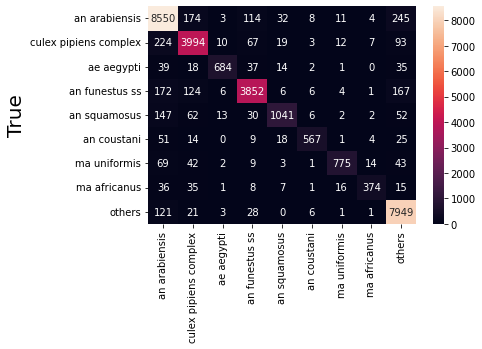

Epoch: 0, Train Loss: 0.15129735, Train Acc: 0.93154520, Val Loss: 0.00064668, Val Acc: 0.94648003, overrun_counter 0


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 1batch = 0 of 760duraation = 0.08740099271138509
epoch = 1batch = 200 of 760duraation = 5.103922379016876
epoch = 1batch = 400 of 760duraation = 10.037957859039306
epoch = 1batch = 600 of 760duraation = 15.210366690158844
Epoch: 1, Train Loss: 0.14773100, Train Acc: 0.93109233, Val Loss: 0.00081771, Val Acc: 0.93272952, overrun_counter 1


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 2batch = 0 of 760duraation = 0.09097945690155029
epoch = 2batch = 200 of 760duraation = 5.069460777441661
epoch = 2batch = 400 of 760duraation = 10.071272830168406
epoch = 2batch = 600 of 760duraation = 15.211302244663239
Epoch: 2, Train Loss: 0.15557077, Train Acc: 0.92805607, Val Loss: 0.00095701, Val Acc: 0.92083162, overrun_counter 2


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 3batch = 0 of 760duraation = 0.08750891288121541
epoch = 3batch = 200 of 760duraation = 5.075666379928589
epoch = 3batch = 400 of 760duraation = 10.061673629283906
epoch = 3batch = 600 of 760duraation = 15.241475530465443
Epoch: 3, Train Loss: 0.15474300, Train Acc: 0.92914707, Val Loss: 0.00073649, Val Acc: 0.93919308, overrun_counter 3


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 4batch = 0 of 760duraation = 0.0966240366299947
epoch = 4batch = 200 of 760duraation = 5.056578584512075
epoch = 4batch = 400 of 760duraation = 10.059785962104797
epoch = 4batch = 600 of 760duraation = 15.233754857381184
Epoch: 4, Train Loss: 0.15249497, Train Acc: 0.92974403, Val Loss: 0.00088240, Val Acc: 0.92713051, overrun_counter 4


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 5batch = 0 of 760duraation = 0.09559553861618042
epoch = 5batch = 200 of 760duraation = 5.089252281188965
epoch = 5batch = 400 of 760duraation = 10.10119614203771
epoch = 5batch = 600 of 760duraation = 15.284074707825978
Epoch: 5, Train Loss: 0.15404855, Train Acc: 0.92917795, Val Loss: 0.00099942, Val Acc: 0.91869082, overrun_counter 5


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 6batch = 0 of 760duraation = 0.09271471897761027
epoch = 6batch = 200 of 760duraation = 5.081644952297211
epoch = 6batch = 400 of 760duraation = 10.107091840108236
epoch = 6batch = 600 of 760duraation = 15.253606212139129
Epoch: 6, Train Loss: 0.15373746, Train Acc: 0.93057771, Val Loss: 0.00087431, Val Acc: 0.92770688, overrun_counter 6


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 7batch = 0 of 760duraation = 0.0906633734703064
epoch = 7batch = 200 of 760duraation = 5.0913245717684426
epoch = 7batch = 400 of 760duraation = 10.09410206079483
epoch = 7batch = 600 of 760duraation = 15.24272821744283
Epoch: 7, Train Loss: 0.13954815, Train Acc: 0.93607386, Val Loss: 0.00108774, Val Acc: 0.91325648, overrun_counter 7


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 8batch = 0 of 760duraation = 0.0962272564570109
epoch = 8batch = 200 of 760duraation = 5.041925795873007
epoch = 8batch = 400 of 760duraation = 10.099327218532562
epoch = 8batch = 600 of 760duraation = 15.26885055700938
Epoch: 8, Train Loss: 0.13371909, Train Acc: 0.93855433, Val Loss: 0.00108123, Val Acc: 0.91111569, overrun_counter 8


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 9batch = 0 of 760duraation = 0.09503114223480225
epoch = 9batch = 200 of 760duraation = 5.099860453605652
epoch = 9batch = 400 of 760duraation = 10.081360836823782
epoch = 9batch = 600 of 760duraation = 15.20261718829473
Epoch: 9, Train Loss: 0.12104741, Train Acc: 0.94530615, Val Loss: 0.00097938, Val Acc: 0.92149033, overrun_counter 9


  0%|          | 0/760 [00:00<?, ?it/s]

epoch = 10batch = 0 of 760duraation = 0.09322789907455445
epoch = 10batch = 200 of 760duraation = 5.002251585324605
epoch = 10batch = 400 of 760duraation = 10.038330280780793
epoch = 10batch = 600 of 760duraation = 15.244963479042053


In [ ]:
#model =Model('convnext_small',224)
#train_loader, val_loader, model = None,  classes = classes,n_channels = 1
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))